In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline


In [4]:
train = pd.read_csv("C:\\Users\\asus\\OneDrive\\Documents\\ElevateLabs\\task5\\titanic\\train.csv")     
test = pd.read_csv("C:\\Users\\asus\\OneDrive\\Documents\\ElevateLabs\\task5\\titanic\\test.csv")        
gender_submission = pd.read_csv("C:\\Users\\asus\\OneDrive\\Documents\\ElevateLabs\\task5\\titanic\\gender_submission.csv")  
train.shape, test.shape, gender_submission.shape

((891, 12), (418, 11), (418, 2))

In [5]:
train.head()
train.info()
train.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


In [6]:
missing = train.isnull().sum().sort_values(ascending=False)
(pd.concat([missing, (train.isnull().mean()*100).sort_values(ascending=False)], axis=1)
 .rename(columns={0:'missing_count', 1:'missing_percent'}))

,missing_count,missing_percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


In [7]:
for col in ['Sex','Pclass','Embarked','SibSp','Parch']:
    print(col)
    print(train[col].value_counts(dropna=False))
    print()


Sex
Sex
male      577
female    314
Name: count, dtype: int64

Pclass
Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Embarked
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

SibSp
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

Parch
Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64



In [9]:
def extract_title(name):
    # takes a name like "Braund, Mr. Owen Harris" -> "Mr"
    try:
        return name.split(',')[1].split('.')[0].strip()
    except:
        return np.nan

train['Title'] = train['Name'].apply(extract_title)
test['Title'] = test['Name'].apply(extract_title)


In [10]:
# Group rare titles
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
train['Title'] = train['Title'].replace(rare_titles, 'Rare')
test['Title'] = test['Title'].replace(rare_titles, 'Rare')

In [11]:
# Family size and alone flag
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
train['IsAlone'] = (train['FamilySize'] == 1).astype(int)
test['IsAlone'] = (test['FamilySize'] == 1).astype(int)

In [13]:
# Fill Embarked with mode
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

# Fill Fare missing values
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())


In [14]:
# Age imputation: median by Title
age_map = train.groupby('Title')['Age'].median()
train['Age'] = train.apply(lambda r: age_map[r['Title']] if pd.isnull(r['Age']) else r['Age'], axis=1)
test['Age']  = test.apply(lambda r: age_map.get(r['Title'], train['Age'].median()) if pd.isnull(r['Age']) else r['Age'], axis=1)

In [15]:
# Age bins
train['AgeBin'] = pd.cut(train['Age'], bins=[0,12,20,40,60,120], labels=['child','teen','young_adult','adult','senior'])
test['AgeBin']  = pd.cut(test['Age'],  bins=[0,12,20,40,60,120], labels=['child','teen','young_adult','adult','senior'])

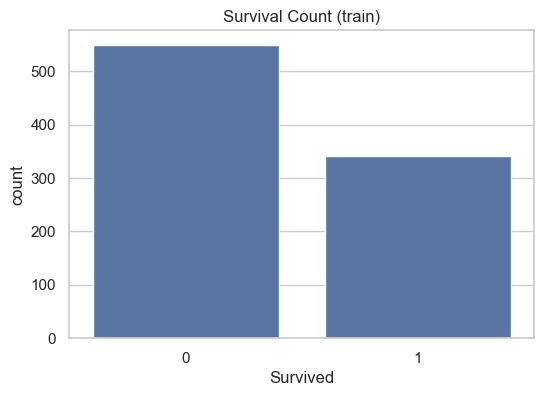

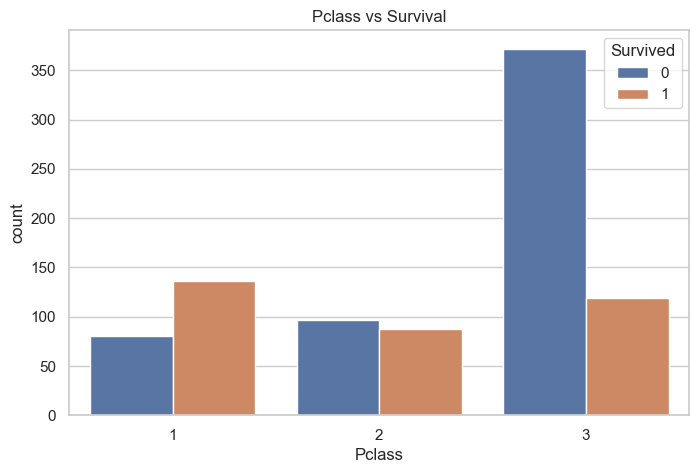

In [24]:
# 7) Univariate and target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=train)
plt.title('Survival Count (train)')
plt.savefig("Survival_Count.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.title('Pclass vs Survival')
plt.savefig("Pclass_VS_Survival.png", dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# 8) Survival rate by Sex, Pclass, Title, Embarked
print("Overall survival rate:", train['Survived'].mean())
print("By sex:\n", train.groupby('Sex')['Survived'].mean())
print("By pclass:\n", train.groupby('Pclass')['Survived'].mean())
print("By Title:\n", train.groupby('Title')['Survived'].mean().sort_values(ascending=False))
print("By Embarked:\n", train.groupby('Embarked')['Survived'].mean())


Overall survival rate: 0.3838383838383838
By sex:
 Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
By pclass:
 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
By Title:
 Title
Mlle            1.000000
Mme             1.000000
Ms              1.000000
the Countess    1.000000
Mrs             0.792000
Miss            0.697802
Master          0.575000
Rare            0.318182
Mr              0.156673
Name: Survived, dtype: float64
By Embarked:
 Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64


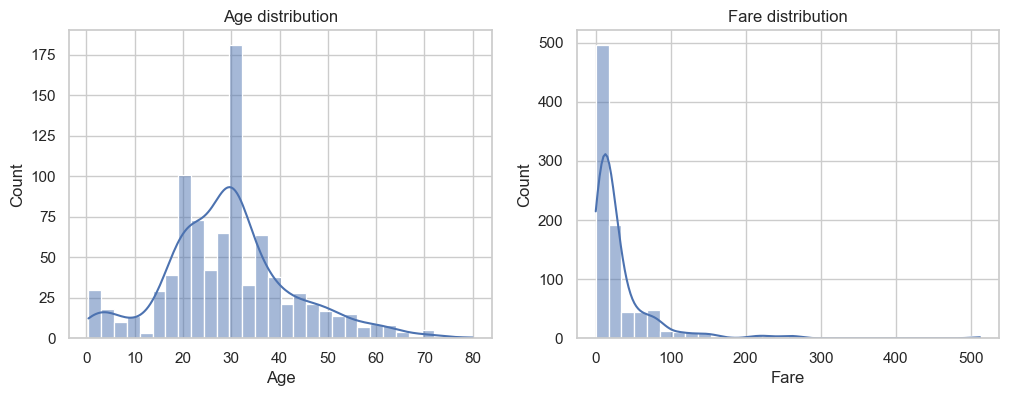

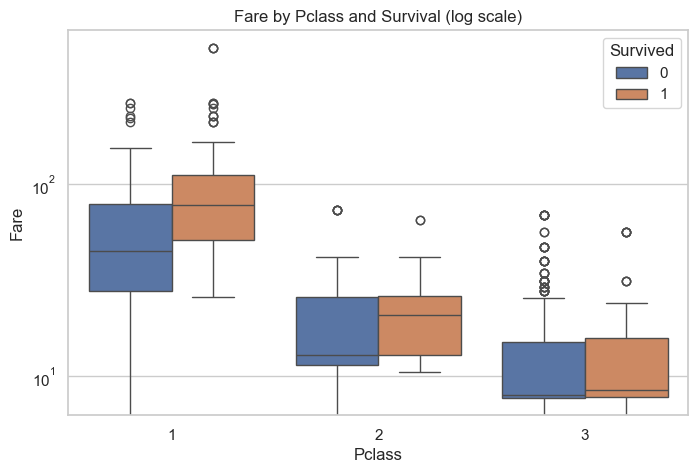

In [23]:
# 9) Age and Fare distributions + boxplot of Fare by Pclass and Survived
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(train['Age'], bins=30, kde=True)
plt.title('Age distribution')
plt.savefig("Age_distribution.png", dpi=300, bbox_inches='tight')

plt.subplot(1,2,2)
sns.histplot(train['Fare'], bins=30, kde=True)
plt.title('Fare distribution')
plt.savefig("Fare_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=train)
plt.yscale('log')  # helps with skew
plt.title('Fare by Pclass and Survival (log scale)')
plt.savefig("Fare_by_Pclass_and_Survival.png", dpi=300, bbox_inches='tight')
plt.show()


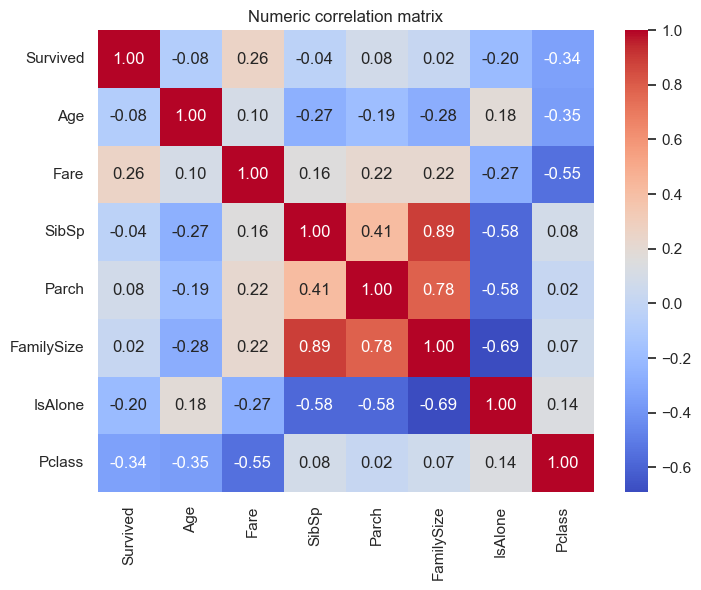

In [22]:
# 10) Correlation heatmap (numeric)
num_cols = ['Survived','Age','Fare','SibSp','Parch','FamilySize','IsAlone','Pclass']
plt.figure(figsize=(8,6))
sns.heatmap(train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric correlation matrix')

plt.savefig("numeric_correlation_heatmap.png", dpi=300, bbox_inches='tight')

plt.show()


In [20]:
# 11) Pivot: survival rate by Pclass and Sex (useful short table)
pivot = pd.pivot_table(train, index='Pclass', columns='Sex', values='Survived', aggfunc='mean')
pivot


Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


In [21]:
# 12) Save cleaned train for further analysis/modeling if needed
train.to_csv('train_cleaned.csv', index=False)
